# Bayesian Multiobjective Optimization
*Joachim van der Herten, Ivo Couckuyt*

## Introduction

This notebook demonstrates the multiobjective optimization of an analytical function using the hypervolume-based probability of improvement function.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import gpflow
import gpflowopt
import numpy as np

We setup the Veldhuizen and Lamont multiobjective optimization problem 2 (vlmop2). The objectives of vlmop2 are very easy to model. Ideal for illustrating Bayesian multiobjective optimization.

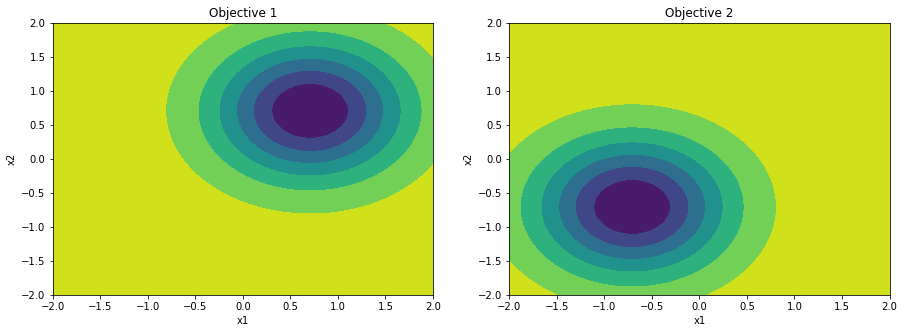

In [2]:
# Objective
def vlmop2(x):
    transl = 1 / np.sqrt(2)
    part1 = (x[:, [0]] - transl) ** 2 + (x[:, [1]] - transl) ** 2
    part2 = (x[:, [0]] + transl) ** 2 + (x[:, [1]] + transl) ** 2
    y1 = 1 - np.exp(-1 * part1)
    y2 = 1 - np.exp(-1 * part2)
    return np.hstack((y1, y2))

# Setup input domain
domain = gpflowopt.domain.ContinuousParameter('x1', -2, 2) + \
         gpflowopt.domain.ContinuousParameter('x2', -2, 2)

# Plot
def plotfx():  
    X = gpflowopt.design.FactorialDesign(101, domain).generate()
    Z = vlmop2(X)
    shape = (101, 101)
    
    axes = []
    plt.figure(figsize=(15, 5))
    for i in range(Z.shape[1]):
        axes = axes + [plt.subplot2grid((1, 2), (0, i))]

        axes[-1].contourf(X[:,0].reshape(shape), X[:,1].reshape(shape), Z[:,i].reshape(shape))
        axes[-1].set_title('Objective {}'.format(i+1))
        axes[-1].set_xlabel('x1')
        axes[-1].set_ylabel('x2')
        axes[-1].set_xlim([domain.lower[0], domain.upper[0]])
        axes[-1].set_ylim([domain.lower[1], domain.upper[1]])
    
    return axes

plotfx();

## Multiobjective acquisition function

We can model the belief of each objective by one GP prior or model each objective separately using a GP prior. We illustrate the latter approach here. A set of data points arranged in a Latin Hypercube is evaluated on the vlmop2 function.

In multiobjective optimization the definition of improvement is ambigious. Here we define improvement using the contributing hypervolume which will determine the focus on density and uniformity of the Pareto set during sampling. For instance, due to the nature of the contributing hypervolume steep slopes in the Pareto front will be sampled less densely. The hypervolume-based probability of improvement is based on the model(s) of the objective functions (vlmop2) and aggregates all the information in one cost function which is a balance between:

- improving our belief of the objectives (high uncertainty)
- favoring points improving the Pareto set (large contributing hypervolume with a likely higher uncertainty)
- focussing on augmenting the Pareto set (small contributing hypervolume but with low uncertainty). 

In [3]:
# Initial evaluations
design = gpflowopt.design.LatinHyperCube(11, domain)
X = design.generate()
Y = vlmop2(X)

# One model for each objective
objective_models = [gpflow.gpr.GPR(X.copy(), Y[:,[i]].copy(), gpflow.kernels.Matern52(2, ARD=True)) for i in range(Y.shape[1])]
for model in objective_models:
    model.likelihood.variance = 0.01

hvpoi = gpflowopt.acquisition.HVProbabilityOfImprovement(objective_models)

## Running the Bayesian optimizer

The optimization surface of multiobjective acquisition functions can be even more challenging than, e.g., standard expected improvement. Hence, a hybrid optimization scheme is preferred: a Monte Carlo optimization step first, then optimize the point with the best value.

We then run the Bayesian Optimization and allow it to select up to 20 additional decisions. 

In [4]:
# First setup the optimization strategy for the acquisition function
# Combining MC step followed by L-BFGS-B
acquisition_opt = gpflowopt.optim.StagedOptimizer([gpflowopt.optim.MCOptimizer(domain, 1000), 
                                                   gpflowopt.optim.SciPyOptimizer(domain)])

# Then run the BayesianOptimizer for 20 iterations
optimizer = gpflowopt.BayesianOptimizer(domain, hvpoi, optimizer=acquisition_opt, verbose=True)
result = optimizer.optimize([vlmop2], n_iter=20)

print(result)
print(optimizer.acquisition.pareto.front.value)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
iter #  0 - MLL [-16.1, -15.6] - fmin [0.385, 0.0171] (size 5)
iter #  1 - MLL [-17.1, -15.7] - fmin [0.385, 0.0171] (size 4)
iter #  2 - MLL [-17.2, -15.6] - fmin [0.385, 0.0171] (size 5)
iter #  3 - MLL [-16.9, -15.4] - fmin [0.104, 0.0171] (size 5)
iter #  4 - MLL [-15.6, -14.2] - fmin [0.104, 0.0171] (size 6)
iter #  5 - MLL [-12.8, -12.9] - fmin [0.0173, 0.0171] (size 7)
iter #  6 - MLL [-10.4, -11.6] - fmin [0.0173, 0.0171] (size 8)
iter #  7 - MLL [-9.08, -8.63] - fmin [0.0173, 0.0171] (size 9)
iter #  8 - MLL [-6.04, -5.29] - fmin [0.0173, 0.0171] (size 10)
iter #  9 - MLL [-3.42, -2.42] - fmin [0.0173, 0.0171] (size 11)
iter # 10 - MLL [0.634, 1.23] - fmin [0.0173, 0.0171] (size 12)
iter # 11 - MLL [3.85, 5.12] - fmin [0.0173, 0.0171] (size 13)
iter # 12 - MLL [6.22, 9.49] - fmin [0.0173, 0.0075] (size 13)
iter # 13 - MLL [9.52, 13.4] - fmin [0.0173, 0.0075] (size 14)
iter # 14 - MLL [13.1, 18.1] - fmin [

For multiple objectives the returned `OptimizeResult` object contains the identified Pareto set instead of just a single optimum. Note that this is computed on the raw data Y.

The hypervolume-based probability of improvement operates on the Pareto set derived from the model predictions of the training data (to handle noise). This latter Pareto set can be found as `optimizer.acquisition.pareto.front.value`.

## Plotting the results

Lets plot the belief of the final models and acquisition function.

name.kern.lengthscales transform:+ve prior:None
[0.5838501  0.59262748]
name.kern.variance transform:+ve prior:None
[3.88573726]
name.likelihood.variance transform:+ve prior:None
[1.00000005e-06]

name.kern.lengthscales transform:+ve prior:None
[0.60790817 0.58374295]
name.kern.variance transform:+ve prior:None
[3.34354369]
name.likelihood.variance transform:+ve prior:None
[1.00000004e-06]



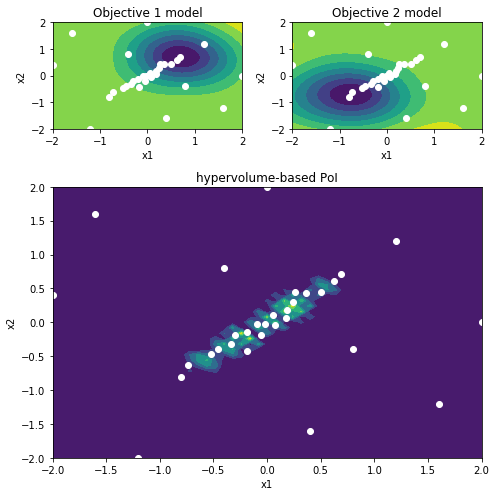

In [5]:
def plot():
    grid_size = 51  # 101
    shape = (grid_size, grid_size)
    
    Xeval = gpflowopt.design.FactorialDesign(grid_size, domain).generate()
    
    Yeval_1, _ = hvpoi.models[0].predict_f(Xeval)
    Yeval_2, _ = hvpoi.models[1].predict_f(Xeval)
            
    Yevalc = hvpoi.evaluate(Xeval)
    
    plots = [((0,0), 1, 1, 'Objective 1 model', Yeval_1[:,0]),
             ((0,1), 1, 1, 'Objective 2 model', Yeval_2[:,0]),
             ((1,0), 2, 2, 'hypervolume-based PoI', Yevalc)]

    plt.figure(figsize=(7,7))
    for i, (plot_pos, plot_rowspan, plot_colspan, plot_title, plot_data) in enumerate(plots):
        data = hvpoi.data[0]
            
        ax = plt.subplot2grid((3, 2), plot_pos, rowspan=plot_rowspan, colspan=plot_colspan)
        ax.contourf(Xeval[:,0].reshape(shape), Xeval[:,1].reshape(shape), plot_data.reshape(shape))
        ax.scatter(data[:,0], data[:,1], c='w')
        ax.set_title(plot_title)
        ax.set_xlabel('x1')
        ax.set_ylabel('x2')
        ax.set_xlim([domain.lower[0], domain.upper[0]])
        ax.set_ylim([domain.lower[1], domain.upper[1]])
    plt.tight_layout()
    
# Plot representing the model belief, and the belief mapped to EI and PoF
plot()

for model in objective_models:
    print(model)

Finally, we can extract and plot the Pareto front ourselves using the `pareto.non_dominated_sort` function on the final data matrix Y.

The non-dominated sort returns the Pareto set (non-dominated solutions) as well as a dominance vector holding the number of dominated points for each point in Y. For example, we could only select the points with dom == 2, or dom == 0 (the latter retrieves the non-dominated solutions). Here we choose to use the dominance vector to color the points.

R: [1.5 1.5]
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Hypervolume indicator: 1.5606701453857534


Text(0,0.5,'Objective 2')

<Figure size 648x288 with 0 Axes>

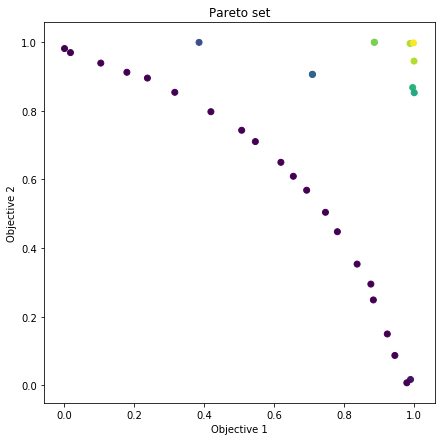

In [6]:
# plot pareto front
plt.figure(figsize=(9, 4))

R = np.array([1.5, 1.5])
print('R:', R)
hv = hvpoi.pareto.hypervolume(R)
print('Hypervolume indicator:', hv)

plt.figure(figsize=(7, 7))

pf, dom = gpflowopt.pareto.non_dominated_sort(hvpoi.data[1])

plt.scatter(hvpoi.data[1][:,0], hvpoi.data[1][:,1], c=dom)
plt.title('Pareto set')
plt.xlabel('Objective 1')
plt.ylabel('Objective 2')